# Analysis choice justification

We have a 2 years dataset of hostel cancelation, ending at end of the 2017 summer touristic season, a potential hostel manager could be interested at estimating the cancelation at the end of the winter season like february, say 6 month forward. 26 weeks. this will be our justification for our training and test set.

In [194]:
import pandas as pd
import numpy as np
from pydlm import dlm, trend, seasonality, longSeason, modelTuner, autoReg
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
raw_data = pd.read_csv('C:/Users/amaur/Documents/Data_science/Bayesian_TS/pydlm_toy.csv')
raw_data.head()

,Date,IsCanceled
0,2015-06-21,97
1,2015-06-28,153
2,2015-07-05,228
3,2015-07-12,321
4,2015-07-19,159


## Formatting data

In [4]:
raw_data['Date'] = pd.to_datetime(raw_data['Date'])

# Calculate min and max date
min_date = raw_data['Date'].min()
max_date = raw_data['Date'].max()

# Generate weekly interval using pandas date_range
weekly_dates = pd.date_range(start=min_date, end=max_date, freq='W')

# Convert the pandas DatetimeIndex to a numpy.ndarray with datetime64 type
cancelation_dates = weekly_dates.to_numpy(dtype=np.datetime64)
cancelation_dates = cancelation_dates.astype('datetime64[W]')

## date printing formater 
cancelation_loc = mdates.DayLocator(interval=31)
cancelation_fmt = mdates.DateFormatter('%Y-%m')

## Number of forcasting steps (half a year)
num_forecast_steps = 26

## Formating time serie data
serial_data = raw_data.IsCanceled.tolist()
serial_data = np.array(serial_data).astype(np.float32)
## Training_data
training_data = serial_data[:-num_forecast_steps]
test_data = serial_data[len(serial_data)-num_forecast_steps:]

## Visual exploration and first decomposition and AR(I)MA process analysis

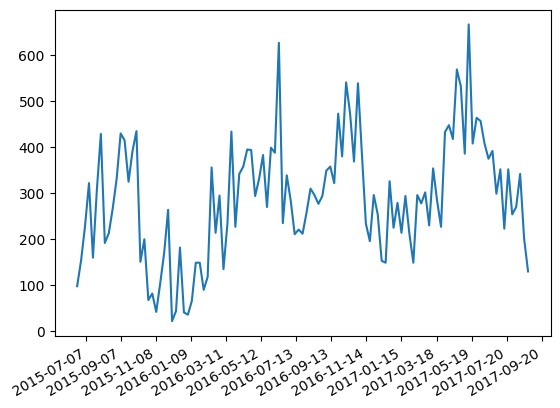

In [5]:
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=62))
plt.plot(raw_data.Date, raw_data.IsCanceled)
plt.gcf().autofmt_xdate()
plt.show()

#### Serie decomposition

<Figure size 1000x800 with 0 Axes>

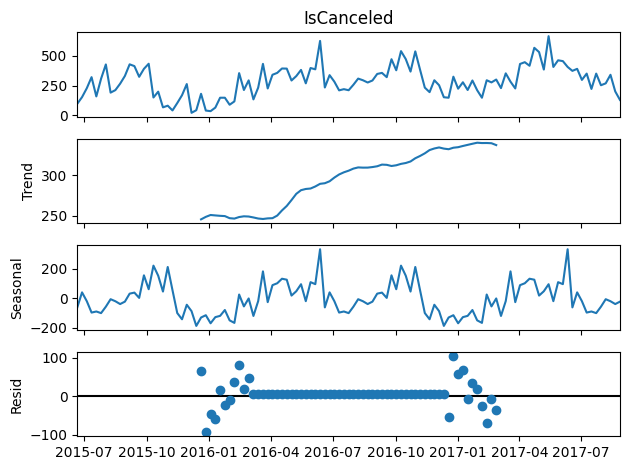

In [6]:
indexed_raw_data = raw_data.set_index('Date')
indexed_raw_data.index.freq = 'W'
decomposition = seasonal_decompose(indexed_raw_data['IsCanceled'], model='additive')
plt.figure(figsize=(10, 8))
decomposition.plot()
plt.show()

Clearly we have
- a positive linear trend, however we see a first phase of constant trend, we will therefore allow a fairly good flexibility to the trend modelling by letting a low discount factor, and relative uncertainty on the prior of the covariance matrix
- a yearly seasonnality that is a bit clearer both quarterly (infra year) and monthly(infra month)

#### Autoregressive structure

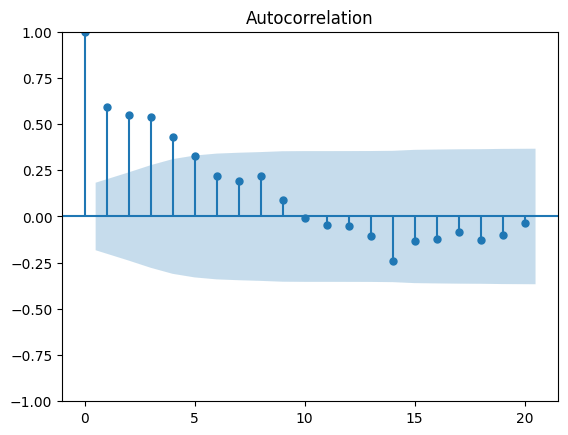

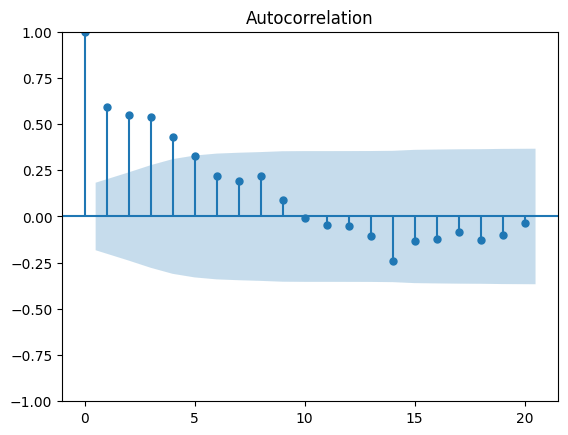

In [7]:
acf,confidence_interval=sm.tsa.acf(serial_data, nlags=20 ,alpha=0.05, fft=False)
plot_acf(serial_data, lags=20)

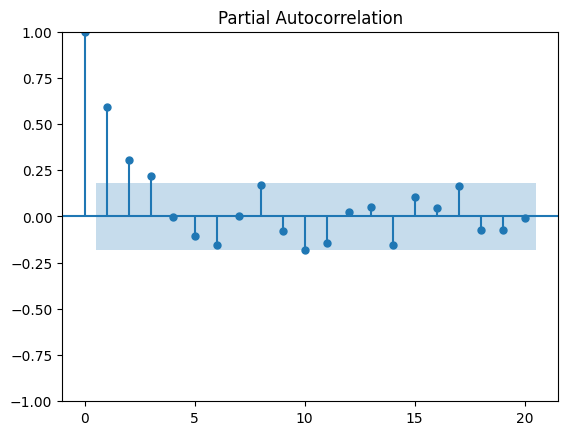

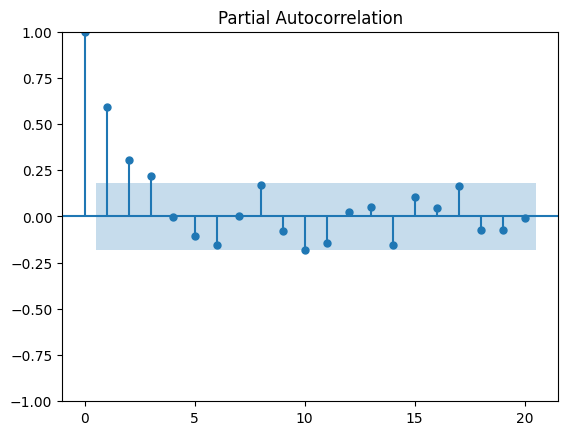

In [8]:
pacf,confidence_interval=sm.tsa.pacf(serial_data, nlags=20 ,alpha=0.05)
plot_pacf(serial_data, lags=20)

An ARMA(3,4) seems to fit our process so we want to include it into our modeling

## Modelling with pydlm

The static components are
local_linear_trend (degree = 2)
seasonality (degree = 52)
 
There is no dynamic component.
 
The automatic components are
longSeason (dimension = 4)


In [78]:
from pydlm import dlm, trend, seasonality, longSeason
import numpy as np

def optimize_dlm(serial_data):
    w_values = [0.3, 0.5, 0.7, 1, 2, 3] # You can expand this list
    discount_values = [0.7, 0.8, 0.9] # You can expand this list

    best_rmse = float('inf')
    best_setup = None

    for w1 in w_values:
        for d1 in discount_values:
            for w2 in w_values:
                for d2 in discount_values:
                    for w3 in w_values:
                        for d3 in discount_values:
                            for include_quarterly in [True, False]:
                                
                                main_DLM_component = dlm(serial_data)
                                local_trend = trend(1, name='local_linear_trend', discount=d1, w=w1)
                                monthly = seasonality(period=52, discount=d2, w=w2)

                                model = main_DLM_component + local_trend + monthly
                                
                                if include_quarterly:
                                    quarterly = longSeason(period=4, stay=13, discount=d3, data=serial_data, w=w3)
                                    model += quarterly

                                model.fit()
                                mse = model.getMSE()
                                rmse = np.sqrt(mse)

                                if rmse < best_rmse:
                                    best_rmse = rmse
                                    best_setup = {
                                        'w1': w1, 'd1': d1,
                                        'w2': w2, 'd2': d2,
                                        'w3': w3, 'd3': d3,
                                        'include_quarterly': include_quarterly
                                    }

    return best_setup

best_setup = optimize_dlm(serial_data)
print(best_setup)


Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing com

In [ ]:
# best set up in term of RMSE minimization
#{'w1': 3, 'd1': 0.7, 'w2': 0.3, 'd2': 0.7, 'w3': 0.7, 'd3': 0.7, 'include_quarterly': True}

In [182]:
main_DLM_component = dlm(serial_data)

local_trend = trend(1, name = 'local_linear_trend', discount=0.9, w=0.3)

monthly = seasonality(period=52, discount=0.95,  w=0.3)

quarterly = longSeason(period=4, stay=13, discount=0.95, data=serial_data, w=0.3)

simpleDLM = main_DLM_component + local_trend + monthly + quarterly

simpleDLM.ls()

simpleDLM.fit()

simpleDLM.getMSE()

The static components are
local_linear_trend (degree = 2)
seasonality (degree = 52)
 
There is no dynamic component.
 
The automatic components are
longSeason (dimension = 4)
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


12709.506035315084

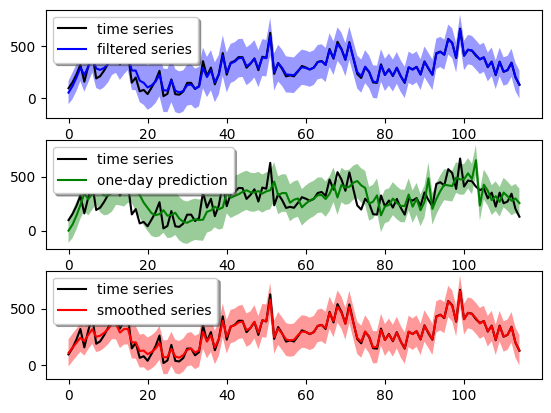

In [183]:
simpleDLM.turnOff('data points')
simpleDLM.plot()

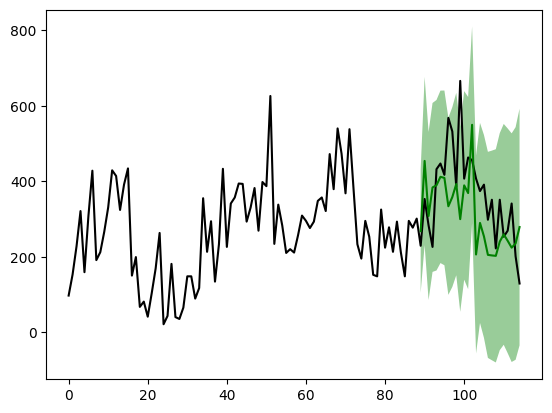

In [184]:
# Plot the prediction give the first 351 weeks and forcast the next 200 weeks.
simpleDLM.setConfidence(p = 0.5)
simpleDLM.plotPredictN(date = 89, N=26)

Trying to minimize RMSE does not lead to the model leading to the best long run prediction (Is that an overfitting problem) !
Tried to find a compromize by hand but there might be a better way to do so.

In [213]:
main_DLM_component = dlm(serial_data)

local_trend = trend(1, name = 'local_linear_trend')

monthly = seasonality(period=52)

quarterly = longSeason(period=4, stay=13, data=serial_data)

initDLM = main_DLM_component + local_trend + monthly + quarterly

initDLM.ls()

simpleDLM.getMSE()

The static components are
local_linear_trend (degree = 2)
seasonality (degree = 52)
 
There is no dynamic component.
 
The automatic components are
longSeason (dimension = 4)


12709.506035315084

In [214]:
## Let us try the modelTuner function
myTuner = modelTuner(method='gradient_descent', loss='mse')
tunedDLM = myTuner.tune(initDLM, maxit=500)

Initializing models...
Initialization finished.
The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.


In [215]:
tunedDLM.fitForwardFilter()
# fit backward smoother
tunedDLM.fitBackwardSmoother()

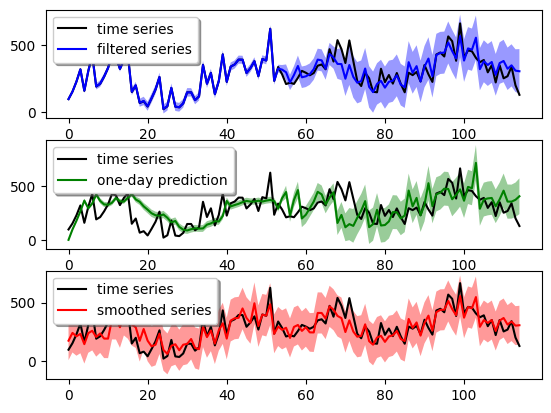

In [216]:
tunedDLM.plot()

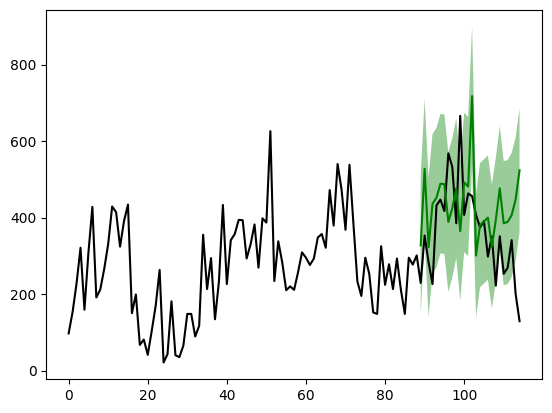

In [217]:
tunedDLM.plotPredictN(date = 89, N=26)

Using the Tuned DLM method is clearly not a good option as it fails to converge and find reasonnable parameters for the discount factor

# Let us add the AR component

In [201]:
main_DLM_component = dlm(serial_data)

local_trend = trend(1, name = 'local_linear_trend', discount=0.9, w=0.3)

monthly = seasonality(period=52, discount=0.95,  w=0.3)

quarterly = longSeason(period=4, stay=13, discount=0.95, data=serial_data, w=0.3)

AR = autoReg(degree=4, name='autoreg', discount = 1 )

ar_DLM = main_DLM_component + local_trend + monthly + quarterly + AR

ar_DLM.ls()

ar_DLM.fit()

ar_DLM.getMSE()

The static components are
local_linear_trend (degree = 2)
seasonality (degree = 52)
 
There is no dynamic component.
 
The automatic components are
longSeason (dimension = 4)
autoreg (dimension = 4)
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


17091.677152809985

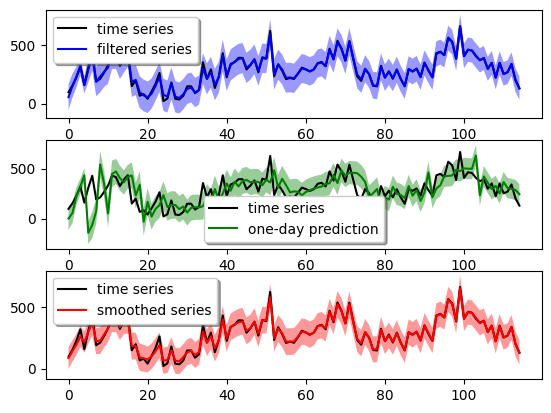

In [202]:
ar_DLM.turnOff('data points')
ar_DLM.plot()

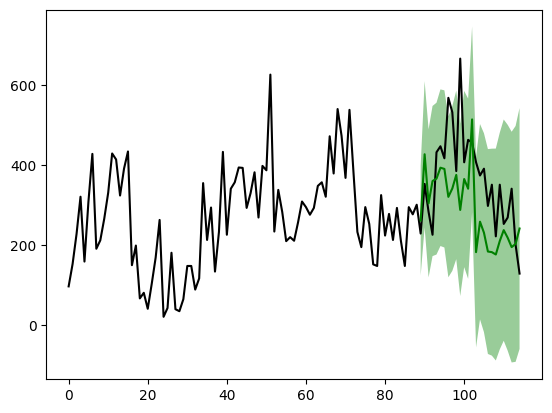

In [203]:
# Plot the prediction give the first 351 weeks and forcast the next 200 weeks.
ar_DLM.setConfidence(p = 0.5)
ar_DLM.plotPredictN(date = 89, N=26)

The RMSE is increased with respect to the initial model. However and this is not surprising as more information is added at each step, the CI is reduced with respect to the initial model

#### Also try using the tuning method

In [218]:
myTuner = modelTuner(method='gradient_descent', loss='mse')
tuned_ar_DLM = myTuner.tune(ar_DLM, maxit=500)

The algorithm stops without converging.
Possible reason: some discount is too close to 1 or 0.7 (0.7 is smallest discount that is permissible.


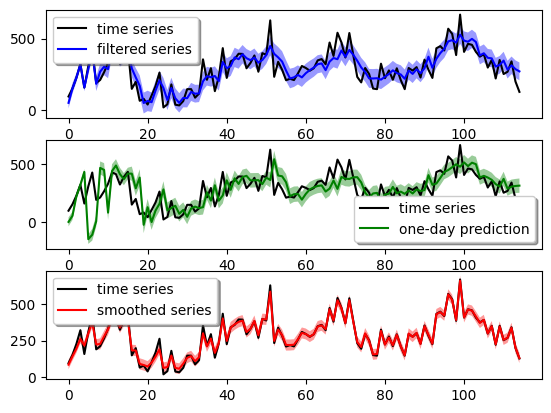

In [219]:
tuned_ar_DLM.fitForwardFilter()
tuned_ar_DLM.fitBackwardSmoother()

tuned_ar_DLM.plot()

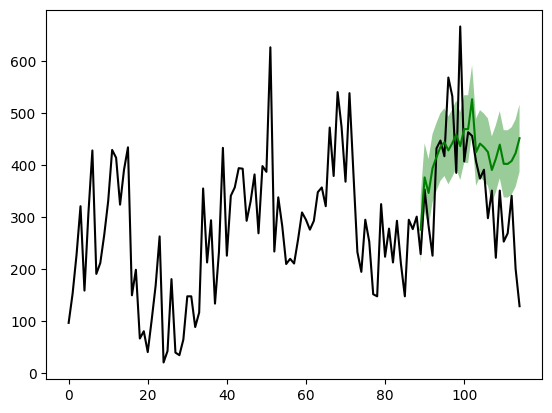

In [220]:
tuned_ar_DLM.plotPredictN(date = 89, N=26)

Here the prediction is less accurate, but the CI is smaller that our hand tuned model.